## PTQ Workflow
![Image](https://miro.medium.com/v2/resize:fit:720/format:webp/1*AMaEC9EuJ3mimb5NztcK-A.png)

## 1. Preprocessing the Model
The pre-processing consists of the following optional steps
- Symbolic Shape Inference. It works best with transformer models.
- ONNX Runtime Model Optimization.
- ONNX Shape Inference.

Quantization requires tensor shape information to perform its best. Model optimization also improve the performance of quantization. For instance, a Convolution node followed by a BatchNormalization node can be merged into a single node during optimization. Currently we can not quantize BatchNormalization by itself, but we can quantize the merged Convolution + BatchNormalization node.



It is highly recommended to run model optimization in pre-processing instead of in quantization. To learn more about each of these steps and finer controls, run:

In [7]:
# Preprocessing the model
!python -m onnxruntime.quantization.preprocess --input ../../../models/assets/yolov8n.onnx --output ../../../models/assets/yolov8n_pre.onnx 

## 2. Quantization: Dynamic Quantization


In [44]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = '../../../models/assets/yolov8n_pre.onnx'

model = onnx.load(model_fp32)

conv_nodes = []
for node in model.graph.node:
    if node.op_type == "Conv":
        conv_nodes.append(node.name)
print(conv_nodes)

['/model.0/conv/Conv', '/model.1/conv/Conv', '/model.2/cv1/conv/Conv', '/model.2/m.0/cv1/conv/Conv', '/model.2/m.0/cv2/conv/Conv', '/model.2/cv2/conv/Conv', '/model.3/conv/Conv', '/model.4/cv1/conv/Conv', '/model.4/m.0/cv1/conv/Conv', '/model.4/m.0/cv2/conv/Conv', '/model.4/m.1/cv1/conv/Conv', '/model.4/m.1/cv2/conv/Conv', '/model.4/cv2/conv/Conv', '/model.5/conv/Conv', '/model.6/cv1/conv/Conv', '/model.6/m.0/cv1/conv/Conv', '/model.6/m.0/cv2/conv/Conv', '/model.6/m.1/cv1/conv/Conv', '/model.6/m.1/cv2/conv/Conv', '/model.6/cv2/conv/Conv', '/model.7/conv/Conv', '/model.8/cv1/conv/Conv', '/model.8/m.0/cv1/conv/Conv', '/model.8/m.0/cv2/conv/Conv', '/model.8/cv2/conv/Conv', '/model.9/cv1/conv/Conv', '/model.9/cv2/conv/Conv', '/model.12/cv1/conv/Conv', '/model.12/m.0/cv1/conv/Conv', '/model.12/m.0/cv2/conv/Conv', '/model.12/cv2/conv/Conv', '/model.15/cv1/conv/Conv', '/model.15/m.0/cv1/conv/Conv', '/model.15/m.0/cv2/conv/Conv', '/model.15/cv2/conv/Conv', '/model.16/conv/Conv', '/model.22/cv2

In [46]:

model_int8 = '../../../models/assets/yolov8n_dynamic_quantized.onnx'
quantize_dynamic(
    model_fp32,  # Input model
    model_int8,  # Output model
    weight_type=QuantType.QInt8,
    nodes_to_exclude=conv_nodes,
)

## Static Quantization

In [24]:
import numpy as np
from onnxruntime.quantization import CalibrationDataReader, quantize_static, QuantType, QuantFormat
import cv2
import onnxruntime
import matplotlib.pyplot as plt

In [20]:
class ImageCalibrationDataReader(CalibrationDataReader):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.idx = 0
        self.input_name = "images"

    def preprocess(self, frame):
        frame = cv2.imread(frame)
        X = cv2.resize(frame, (640, 640))
        image_data = np.array(X).astype(np.float32) / 255.0  # Normalize to [0, 1] range
        image_data = np.transpose(image_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image_data = np.expand_dims(image_data, axis=0)  # Add batch dimension
        return image_data

    def get_next(self):
        if self.idx >= len(self.image_paths):
            return None

        image_path = self.image_paths[self.idx]
        input_data = self.preprocess(image_path)
        self.idx += 1
        return {self.input_name: input_data}

In [21]:
import os

# Path to the calibration_data folder
calibration_dir = '../../../dataset/calibration_data/'

# Get a sorted list of all jpg files in the folder
image_files = sorted([
    f for f in os.listdir(calibration_dir)
    if f.endswith('.jpg')
])

# Create full relative paths
calibration_image_paths = [os.path.join(calibration_dir, f) for f in image_files]

print(calibration_image_paths)

['../../../dataset/calibration_data/000001_jpg.rf.16f9893d972aac289cba767767299228.jpg', '../../../dataset/calibration_data/000023_jpg.rf.3403a1aa9fa8f6e196277df4d54af350.jpg', '../../../dataset/calibration_data/0002_png.rf.1f3969ffc815bf1217879fad74ed67d3.jpg', '../../../dataset/calibration_data/000615_jpg.rf.f721800e321a71503230ab10e842204a.jpg', '../../../dataset/calibration_data/000812_jpg.rf.bd689a6aaa0a0303e6b443015c5690ef.jpg', '../../../dataset/calibration_data/000819_jpg.rf.1d2383693a7f7685a825ddd8951978e4.jpg', '../../../dataset/calibration_data/2008_000516_jpg.rf.8b48f027e0c08e19441e37ab0987d431.jpg', '../../../dataset/calibration_data/2008_000562_jpg.rf.1ea0888483a955a04e6f447e90d08403.jpg', '../../../dataset/calibration_data/2008_000572_jpg.rf.273c6946348617e24a494fd0c9967317.jpg', '../../../dataset/calibration_data/2008_000605_jpg.rf.4fe5c5519674a922a840ba487000b956.jpg', '../../../dataset/calibration_data/2008_000899_jpg.rf.e9a252b4972af79fbe78910b60dae6bf.jpg', '../../.

In [22]:
# Create an instance of the ImageCalibrationDataReader
calibration_data_reader = ImageCalibrationDataReader(calibration_image_paths)

## Finding the nodes to exclude
* Go to: https://netron.app
* Upload the model
* Scroll to the bottom
* Select the nodes in the botthm layers and collect the names

In [23]:
# Use the calibration_data_reader with quantize_static
model_fp32 = '../../../models/assets/yolov8n_pre.onnx'
model_int8 = '../../../models/assets/yolov8n_static_quantized.onnx'
quantize_static(model_fp32, model_int8,
                weight_type=QuantType.QInt8,
                activation_type=QuantType.QUInt8,
                calibration_data_reader=calibration_data_reader,
                quant_format=QuantFormat.QDQ,
                nodes_to_exclude=['/model.22/Concat_3', '/model.22/Split', '/model.22/Sigmoid'
                                 '/model.22/dfl/Reshape', '/model.22/dfl/Transpose', '/model.22/dfl/Softmax', 
                                 '/model.22/dfl/conv/Conv', '/model.22/dfl/Reshape_1', '/model.22/Slice_1',
                                 '/model.22/Slice', '/model.22/Add_1', '/model.22/Sub', '/model.22/Div_1',
                                  '/model.22/Concat_4', '/model.22/Mul_2', '/model.22/Concat_5'],
                per_channel=True,
                reduce_range=True)

## Inference

In [25]:
def show(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)# Converts the frame to matplotlib format 
    fig, ax = plt.subplots(figsize=(20, 12)) # larger fig size for better visuals
    plt.imshow(frame) # displaying the frame

In [26]:
def preprocessor(frame):
    x = cv2.resize(frame, (640, 640))
    image_data = np.array(x).astype(np.float32) / 255.0  # Normalize to [0, 1] range
    image_data = np.transpose(image_data, (2, 0, 1))  # (H, W, C) -> (C, H, W)
    image_data = np.expand_dims(image_data, axis=0)  # Add batch dimension
    return image_data

In [27]:
class Inference:
    def __init__(self, model, path):
        self.session = onnxruntime.InferenceSession(model, providers=["CPUExecutionProvider"])
        model_inputs = self.session.get_inputs()
        input_shape = model_inputs[0].shape
        self.path = path
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]
        self.classes = {0: 'person'}

    def detector(self, image_data):
        ort = onnxruntime.OrtValue.ortvalue_from_numpy(image_data)
        return self.session.run(["output0"], {"images": ort})

    def draw_detections(self, img, box, score, class_id):
        x1, y1, w, h = box
        color = (0, 255, 0)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)
        label = f'{self.classes[class_id]}: {score:.2f}'
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                      cv2.FILLED)
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
        return img

    def postprocessor(self, results, frame, confidence, iou):
        img_height, img_width = frame.shape[:2]
        outputs = np.transpose(np.squeeze(results[0]))
        rows = outputs.shape[0]
        boxes = []
        scores = []
        class_ids = []
        x_factor = img_width / self.input_width  # img_width = 640
        y_factor = img_height / self.input_height  # img_width = 640
        for i in range(rows):
            classes_scores = outputs[i][4:]
            max_score = np.amax(classes_scores)
            if max_score >= confidence:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)
                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]
                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, confidence, iou)
        for i in indices:
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            frame = self.draw_detections(frame, box, score, class_id)
        return frame

    def pipeline(self):
        frame = cv2.imread(self.path)
        frame = self.postprocessor(self.detector(preprocessor(frame)), frame, 0.35, 0.35)
        return frame

In [47]:
static_quantized = '../../../models/assets/yolov8n_static_quantized.onnx'
dynamic_quantized = '../../../models/assets/yolov8n_dynamic_quantized.onnx'
yolov8n = '../../../models/assets/yolov8n.onnx'

path = '../../../dataset/calibration_data/000615_jpg.rf.f721800e321a71503230ab10e842204a.jpg'

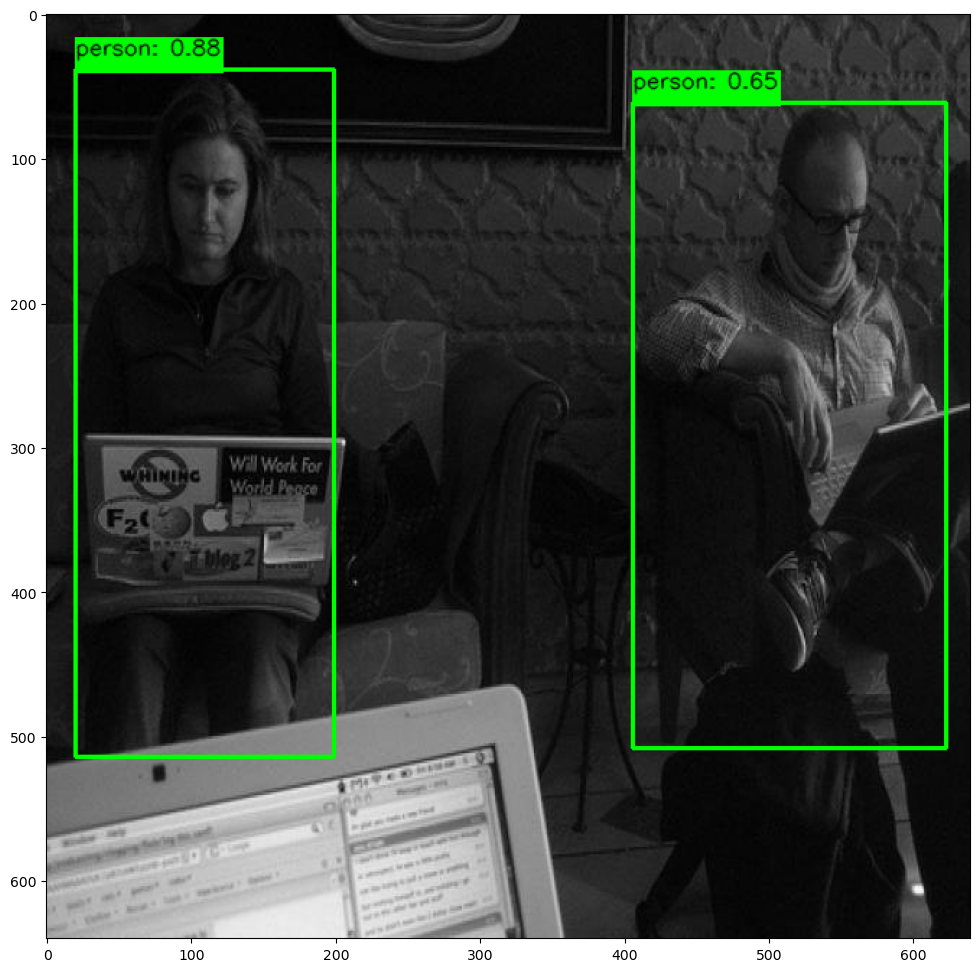

In [31]:
# Using unquantized model
x = Inference(yolov8n, path)
y = x.pipeline()
show(y)

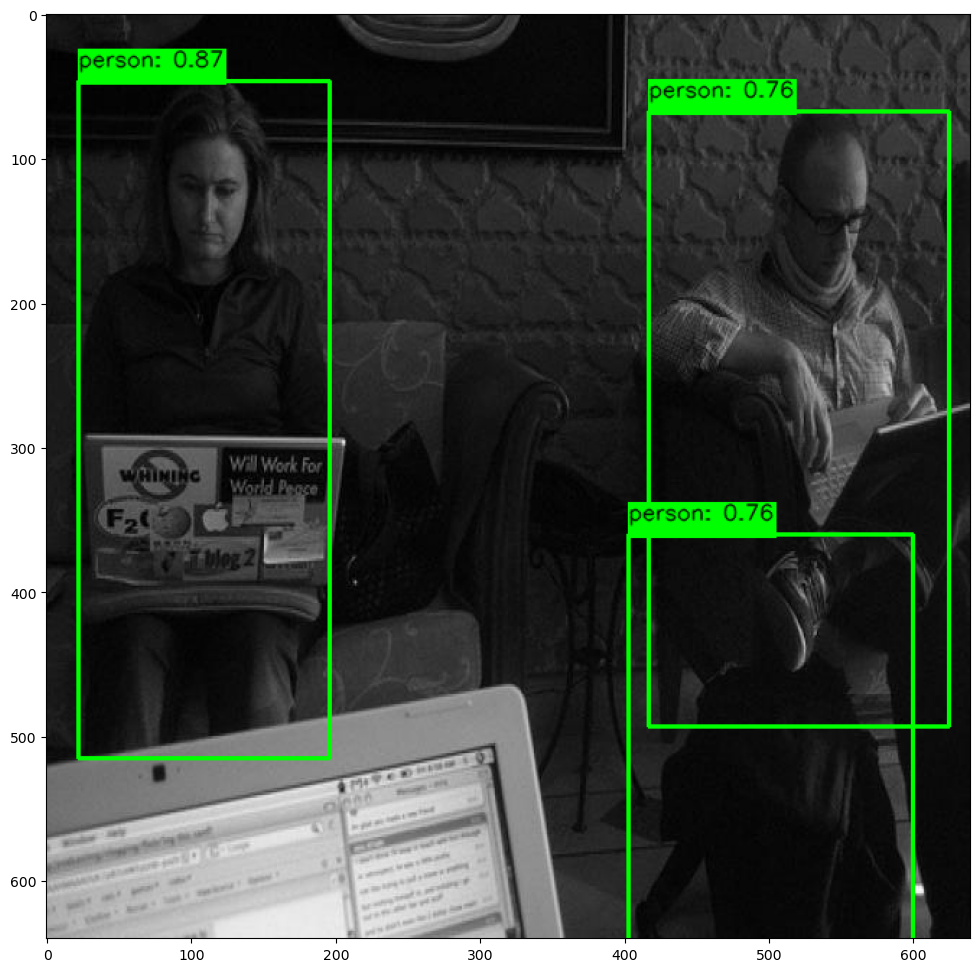

In [32]:
# Using Static quantized model
x = Inference(static_quantized, path)
y = x.pipeline()
show(y)

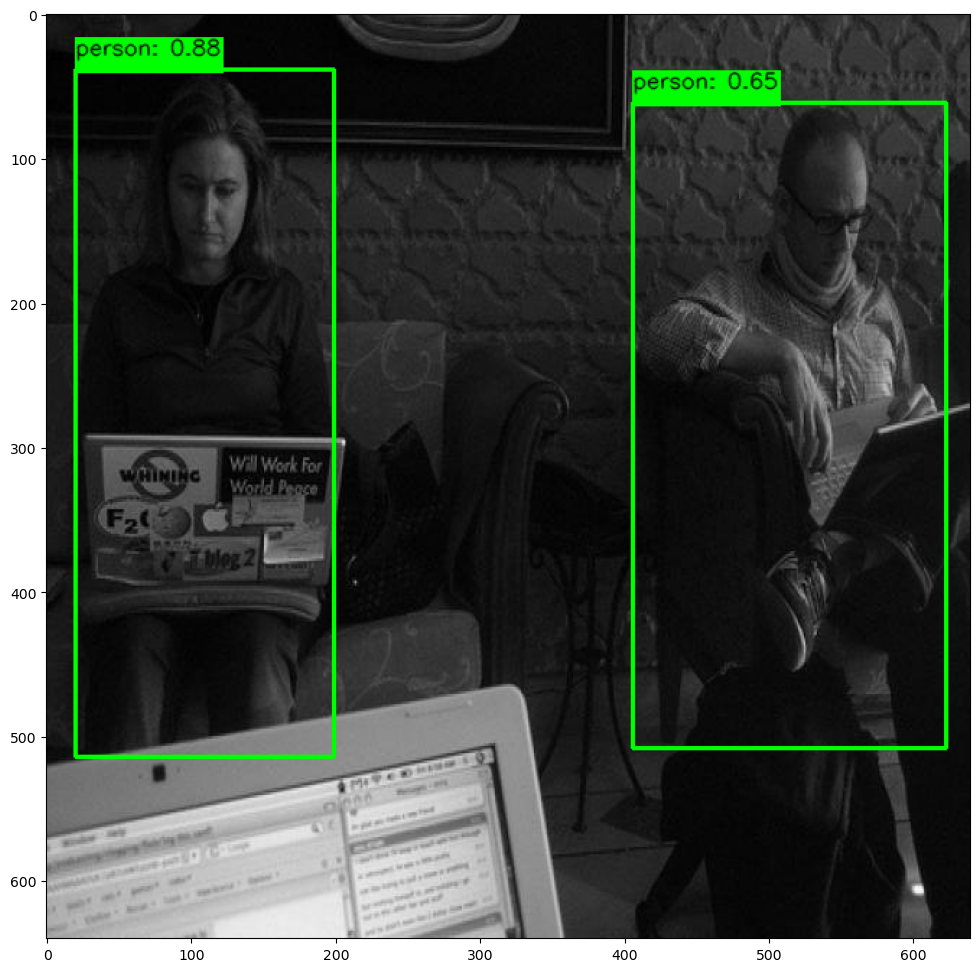

In [48]:
# Using Dynamic quantized model
x = Inference(dynamic_quantized, path)
y = x.pipeline()
show(y)